<a href="https://colab.research.google.com/github/williserdman/Radar-Material-Detection-Exploration/blob/main/water_content_level_bean_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collecting and Loading data

## Collecting

Collecting the data was probably the most complicated part. In the `~/Documents/Radar` (on the Raspberry Pi) folder there should be a run_app.sh executable that will open up Acconeer. Once in A121, click distance detector and connect to the sensor: that's been on `/dev/ttyUSB0` prevously (baud rate 115200 if it doesn't work).

I believe the config that I used will load up by default once you click distance detector. If not it's saved to the Pi and you can load it from file (july12config.json).

When the sensor's all physically set up, just click start measurement and let it run until there have been 15-20 frames taken. It takes ~5 seconds. You will see a point appear on the bottom graph for every frame taken. Once run, (top right) save the measurement to a file.

I followed the naming convention `coffee_type-test_number.h5` and that's what this code expects when processing the data. The code expects you to add each coffee type to a list (below).[link text](https:// [link text](https://))


In [ ]:
import numpy as np
import h5py

In [ ]:
%%capture
%pip install acconeer-exptool
from acconeer.exptool import a121
import os

## Loading the Data
Everything in the root folder of this notebook will be used to train/validation. So, any test data you might have should be uploaded after this step.

In [ ]:
def process_h5(record):
  data = []

  # parsing only the sensor data from acconeer's object (other stuff is config/metadata)
  for elm in record.extended_stacked_results:

    # each frame again has metadata attached, this grabs only the data
    dframe = [elm[key].frame for key in elm.keys()]
    dframe = np.array(dframe)

    # acconeer returns complex num, abs gives amplitude. adju gives phase, shouldn't change for static object (such as this)
  return np.squeeze(abs(dframe))

In [ ]:
# grab all files in root directory
files = os.listdir("./")

# load them using acconeer's function
data_records = [[a121.load_record(f), f] for f in files if f.endswith(".h5")]

# Preprocessing

## Feature extraction
See code comments for more detail. There is some correlation between variables (max and range for instance as min is rather constant), but this hasn't really been presenting as an issue.

!! second code box expects all coffee type names and water %

In [ ]:
from scipy.signal import find_peaks
import statistics

def feature_extraction(test_data):
  # changed from an array of arrays to just one array
  i = test_data

  data = []
  # this is getting the first and second peaks (from cup detection)
  peaks, _ = find_peaks(i)
  sorted_peaks = peaks[np.argsort(i[peaks])][::-1]
  top_two_peaks = sorted_peaks[:2]

  # adding the two peaks with the highest amplitude
  features = i[top_two_peaks].tolist()

  # adding the ratio of the two peaks to the features
  features.append(top_two_peaks[0] / top_two_peaks[1])

  # adding the standard deviation of the peaks to the features
  features.append(statistics.stdev(i))

  # adding the mean of the peaks to the features
  features.append(statistics.mean(i))

  # adding the area under the curve to the features
  features.append(np.trapz(i))

  # adding the variance to the features
  features.append(np.var(i))

  # adding the max
  features.append(np.max(i))

  # adding the min
  features.append(np.min(i))

  # adding the range
  features.append(np.ptp(i))

  # adding the rms
  features.append(np.sqrt(np.mean(i**2)))

  # adding the p2p
  features.append(np.ptp(i))

  # adding that datapoint to the list
  data.append(features)
  return data

#### DATA NEEDED HERE
`label_names` should be a list of the coffee types that are being trained on. `regr_names` should be a list of the coffee's water % (multiplied by 10, but doens't matter as long as they're consistent). The indexes **must** correspond.

In [ ]:
# water % a sliding scale so these are to convert from label names to numbers
label_names = ["gbr458", "gbr558", "gbr658", "gbr758", "gbr958", "gbr1058", "gbr1158"]

# water % (x10 for readability)
regr_names = [27, 19, 17, 15, 13, 13, 11]

data = []
labels = []

for item in data_records:
  # each data record is a list of [record, filename]
  filename = item[1]

  # here's how we know what label to give this record (they're not loaded in in a specific order)
  label = filename.split("-")[0]

  record = item[0]

  # grab meaningful data from record
  temp = process_h5(record).mean(axis=0)

  # extract features
  new_data = feature_extraction(temp)

  # add data to data array and label to label array
  data += new_data
  labels += [label]

In [ ]:
# make sure that nothing went wront
len(data), len(labels)

(22, 22)

In [ ]:
# see below for `astype(float)` usage reasoning (this is here so that you are able to train with all the data, is NN section)
data = np.array(data).astype(float)
labels = np.array(labels)

In [ ]:
# converts the string labels to the regression values
for i, item in enumerate(labels):
  labels[i] = int(regr_names[label_names.index(item)])

In [ ]:
from sklearn.model_selection import train_test_split

# splitting the data into training and validation
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
# something above returns an array of strings that are numbers (['11', '22', ..., '99']), and the labels are '13'. this casts all to float so that regression and NN traning work
X_train = X_train.astype(float)
X_test = X_test.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

## Collab data visualization
Appearently I should have thrown everything into a dataframe earlier as collab offers a button "show recommended plots" which creates like 20 plots comparing features of the data and it's a very very easy way to see what could be important.

In [ ]:
# the neural net expects a dataframe, also allows much easier graphing

# for training data
df_train = pd.DataFrame(X_train, columns=['peak 1', 'peak 2', 'peak1:peak2 ratio', "stdev", "mean", "integral", "variance", "max", "min", "range", "rms", "p2p"])
df_train['label'] = y_train

# for testing data
df_test = pd.DataFrame(X_test, columns=['peak 1', 'peak 2', 'peak1:peak2 ratio', "stdev", "mean", "integral", "variance", "max", "min", "range", "rms", "p2p"])
# df_test['label'] = y_test

# categorial columns (for NN)
cat_names = []

# continuos columns (for NN)
cont_names = ['peak 1', 'peak 2', 'peak1:peak2 ratio', "stdev", "mean", "integral", "variance", "max", "min", "range", "rms", "p2p"]

# for NN
dep_var = 'label'

df_train.head()

,peak 1,peak 2,peak1:peak2 ratio,stdev,mean,integral,variance,max,min,range,rms,p2p,label
0,155.861273,144.430387,1.230769,168.922110,143.475432,8065.352425,28059.101252,1012.975995,32.441743,980.534253,220.554530,980.534253,13.0
1,195.713861,15.292345,1.840000,187.206290,136.681582,7624.026867,34462.091759,1071.711139,13.720930,1057.990209,230.529709,1057.990209,17.0
2,281.800180,277.328045,1.041667,184.463895,188.282896,10671.554844,33459.813244,1077.308135,27.575595,1049.732541,262.507642,1049.732541,19.0
3,112.332060,109.498743,1.061224,186.112375,111.515492,6124.734749,34060.519354,1052.241845,16.082488,1036.159357,215.629832,1036.159357,17.0
4,188.229258,127.807162,0.800000,174.702083,150.861535,8482.121986,30012.137515,1032.037784,27.250585,1004.787199,229.720135,1004.787199,13.0


### Graphs
Every variable and their relation to `label`. Y-axis is always `label`.

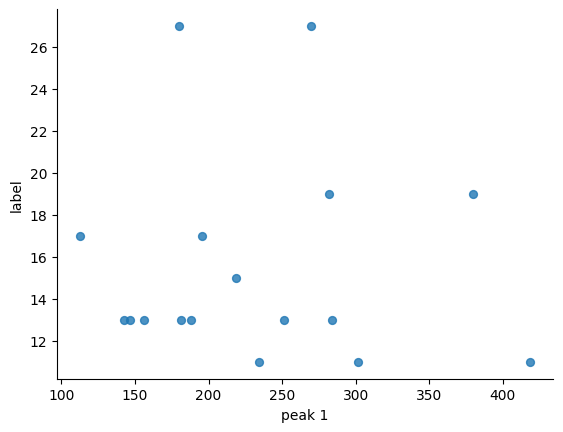

In [ ]:
# @title peak 1 vs label

from matplotlib import pyplot as plt
df_train.plot(kind='scatter', x='peak 1', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

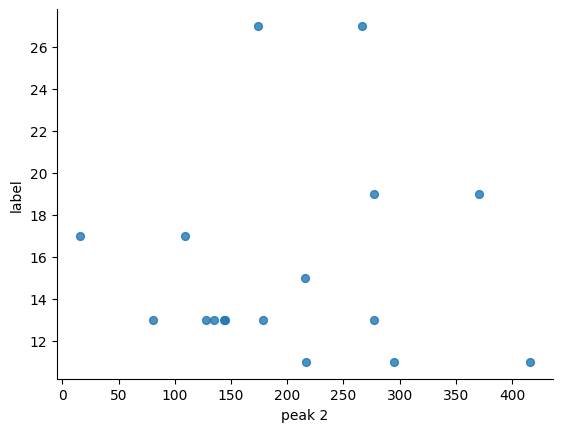

In [ ]:
# @title peak 2 vs label

from matplotlib import pyplot as plt
df_train.plot(kind='scatter', x='peak 2', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

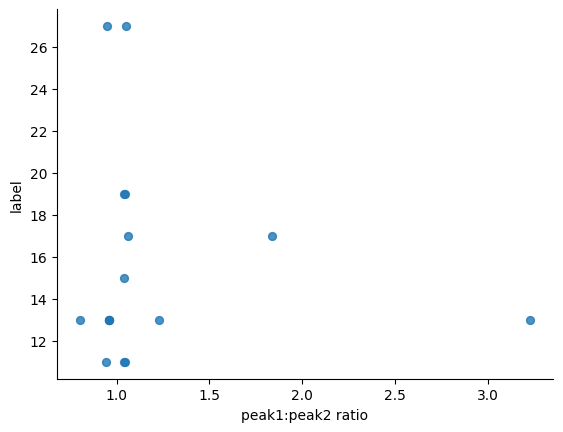

In [ ]:
# @title peak1:peak2 ratio vs. label

from matplotlib import pyplot as plt
df_train.plot(kind='scatter', x='peak1:peak2 ratio', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

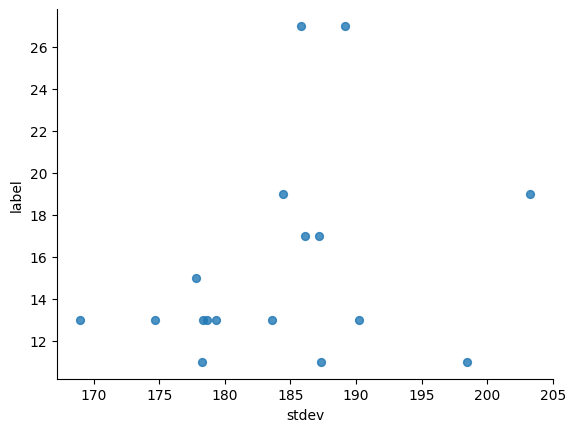

In [ ]:
# @title stdev vs. label

from matplotlib import pyplot as plt
df_train.plot(kind='scatter', x='stdev', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

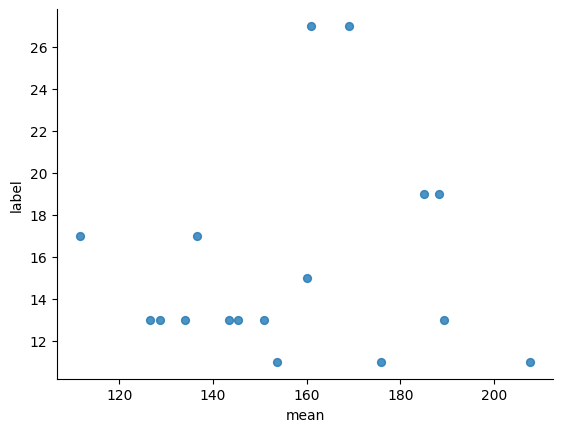

In [ ]:
# @title mean vs. label

from matplotlib import pyplot as plt
df_train.plot(kind='scatter', x='mean', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

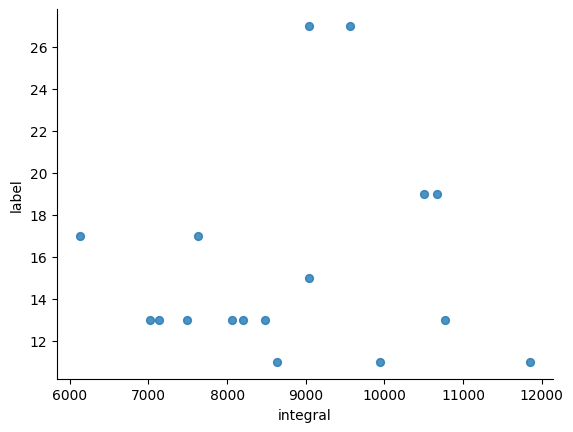

In [ ]:
# @title integral vs. label

from matplotlib import pyplot as plt
df_train.plot(kind='scatter', x='integral', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

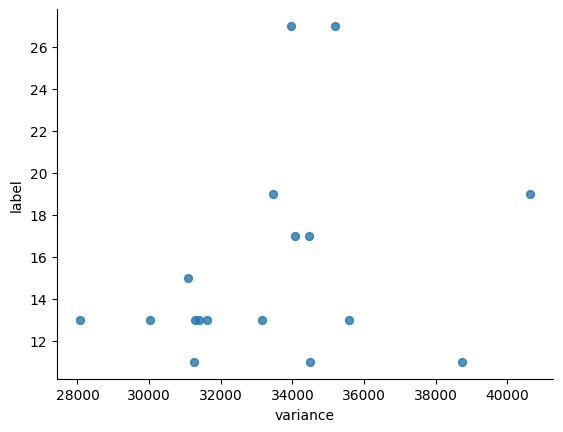

In [ ]:
# @title variance vs. label

from matplotlib import pyplot as plt
df_train.plot(kind='scatter', x='variance', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

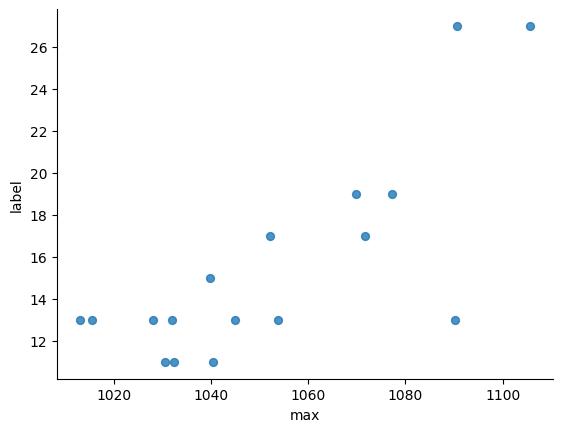

In [ ]:
# @title max vs. label

from matplotlib import pyplot as plt
df_train.plot(kind='scatter', x='max', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

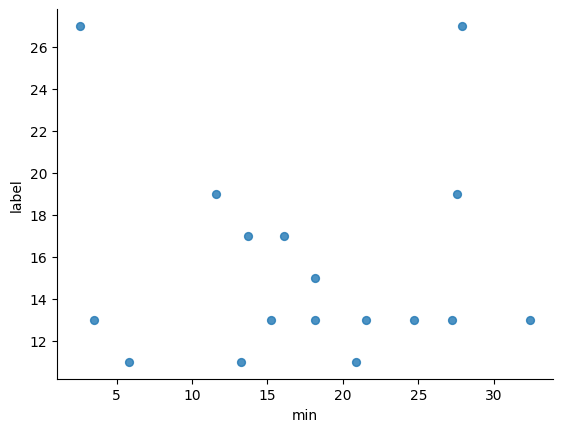

In [ ]:
# @title min vs. label

from matplotlib import pyplot as plt
df_train.plot(kind='scatter', x='min', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

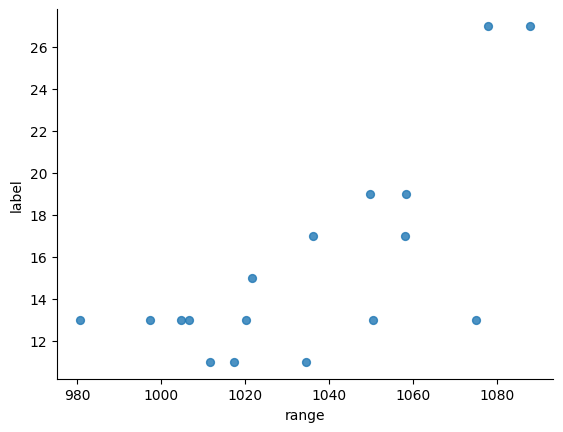

In [ ]:
# @title range vs. label

from matplotlib import pyplot as plt
df_train.plot(kind='scatter', x='range', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

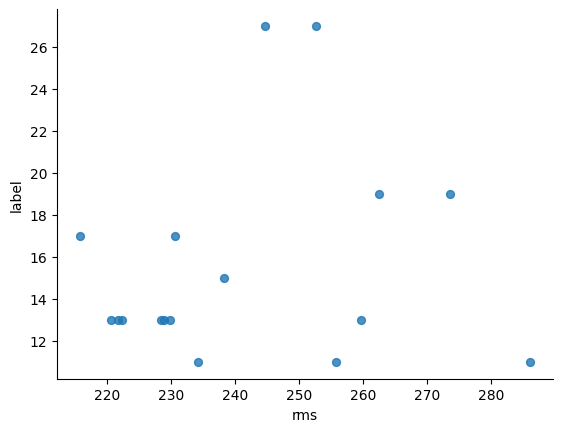

In [ ]:
# @title rms vs. label

from matplotlib import pyplot as plt
df_train.plot(kind='scatter', x='rms', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

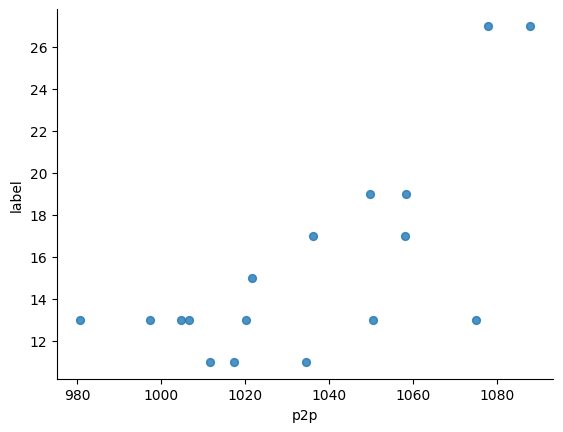

In [ ]:
# @title peak to peak amplitude vs. label

from matplotlib import pyplot as plt
df_train.plot(kind='scatter', x='p2p', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# Models

## Regression

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# linear regression model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

# found that these both performed much better on validation than on an (totally new) test set
accuracy_scrore = mean_squared_error(y_test, y_pred, squared=False)

# accuracy in root mean squared error (RMSE) to preserve units (should be the rmse throughout all)
print(f'on average {accuracy_scrore} points off')

on average 4.455347046144438 points off


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# allows for polynomial fitting with multiple input vars
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)

poly_regr = linear_model.LinearRegression()
poly_regr.fit(X_poly, y_train)

y_pred = poly_regr.predict(poly.fit_transform(X_test))

# accuracy in rmse
accuracy_scrore = mean_squared_error(y_test, y_pred, squared=False)
print(f'on average {accuracy_scrore} points off')

on average 6.505977213645019 points off


## Nerual network
Kind of the magic to classifying this it works rather as expcted. This is an application for going forward, as, at this point in time other simpler solutions have perfect accuracy it does not make sense to use a neural network.

In [ ]:
%%capture
%pip install fastai

from fastai.tabular.all import *
import pandas as pd

In [ ]:
# uncomment to train using all data

# df_train = pd.DataFrame(data, columns=['peak 1', 'peak 2', 'peak1:peak2 ratio', "stdev", "mean", "integral", "variance", "max", "min", "range", "rms", "p2p"])
# df_train['label'] = pd.DataFrame(labels.astype(float))

In [ ]:
# function provided by fastai to load the dataframe into the form it expects. Normalize normalizes the inputs (suprise!). Categorify does nothing in this case but if there were categories it would help deal with them. regression block as opposed to CategoryBlock(). batch size is 4 since there are limited data points (this is ~16% of data)
dls = TabularDataLoaders.from_df(df_train, y_names=dep_var, cat_names=cat_names, cont_names=cont_names, procs=[Categorify, Normalize], y_block=RegressionBlock(), bs=4)

# their tabular learner, layers default to [200,100], y_range is Low and high for the final sigmoid function (not been specified yet). oss function by default for regression is mean squared error specifying metrics just will print out rmse aswell (during training)
learn = tabular_learner(dls, metrics=rmse)

In [ ]:
# Train the model (long output and long time to run)
for i in range(5):

  # learning rate decreases over a cycle. lr_max can be specified. the only required input is number of epochs.
  learn.fit_one_cycle(50)

  # running 5 cycles of 50 epochs is considered better than 250 epochs (b/c of the learning rate changing), (setting y_range above would likely help as the model starts off very wild)

# showing results from the validation set
learn.show_results()

epoch,train_loss,valid_loss,_rmse,time
0,268.013763,183.605713,13.550118,00:00
1,269.170776,184.059402,13.566850,00:00
2,297.924500,184.223740,13.572905,00:00
3,284.494751,184.674896,13.589514,00:00
4,299.549042,186.543564,13.658095,00:00
5,299.073273,188.417206,13.726515,00:00
6,295.669525,193.067841,13.894885,00:00
7,291.079529,197.011932,14.036094,00:00
8,290.061218,204.272263,14.292385,00:00
9,309.230011,222.013290,14.900110,00:00


epoch,train_loss,valid_loss,_rmse,time
0,248.652740,215.955368,14.695420,00:00
1,235.323410,212.330551,14.571567,00:00
2,236.768890,213.734055,14.619646,00:00
3,234.813034,208.833633,14.451077,00:00
4,254.188232,218.900803,14.795297,00:00
5,252.258530,211.323532,14.536971,00:00
6,245.854614,199.905624,14.138799,00:00
7,262.173004,200.972046,14.176461,00:00
8,253.677109,185.351135,13.614372,00:00
9,245.553619,172.285522,13.125758,00:00


epoch,train_loss,valid_loss,_rmse,time
0,146.909882,114.265976,10.689527,00:00
1,147.488297,105.608521,10.276601,00:00
2,151.975372,104.729889,10.233762,00:00
3,144.266693,91.511124,9.566145,00:00
4,141.323898,93.883194,9.689334,00:00
5,154.399261,102.921982,10.145047,00:00
6,155.150055,101.238892,10.061754,00:00
7,151.735168,101.489594,10.074204,00:00
8,158.578705,102.139877,10.106427,00:00
9,153.096252,96.475388,9.822188,00:00


epoch,train_loss,valid_loss,_rmse,time
0,65.010880,43.201019,6.572748,00:00
1,61.312737,41.258793,6.423301,00:00
2,61.549847,41.505516,6.442478,00:00
3,65.619255,41.041306,6.406349,00:00
4,61.229527,37.175468,6.097169,00:00
5,58.124313,31.731640,5.633084,00:00
6,55.531162,25.012667,5.001266,00:00
7,53.980373,23.920053,4.890813,00:00
8,53.333698,24.167814,4.916077,00:00
9,54.214130,24.494417,4.949183,00:00


epoch,train_loss,valid_loss,_rmse,time
0,14.014221,6.618648,2.572673,00:00
1,12.876169,6.642425,2.577290,00:00
2,10.331501,7.387919,2.718073,00:00
3,17.241579,5.694144,2.386241,00:00
4,17.935402,5.735712,2.394935,00:00
5,18.279741,4.310263,2.076117,00:00
6,19.012192,4.506995,2.122968,00:00
7,17.625095,5.087648,2.255582,00:00
8,16.276464,7.885469,2.808108,00:00
9,14.833836,6.420158,2.533803,00:00


,peak 1,peak 2,peak1:peak2 ratio,stdev,mean,integral,variance,max,min,range,rms,p2p,label,label_pred
0,0.862388,0.911474,-0.486479,0.142791,0.849381,0.841347,0.121383,-0.637492,-1.307909,-0.269535,0.717303,-0.269535,11.0,14.608252
1,-0.941521,-0.556717,-0.278240,-0.478164,-0.915547,-0.910425,-0.493296,-0.099496,0.207501,-0.148665,-0.887208,-0.148665,17.0,13.907675
2,-0.596158,-0.836946,-0.755089,-1.432811,-0.204880,-0.201044,-1.406060,-0.913017,1.297662,-1.207167,-0.644701,-1.207167,13.0,15.604506
3,-0.596158,-0.836946,-0.755089,-1.432811,-0.204880,-0.201044,-1.406060,-0.913017,1.297662,-1.207167,-0.644701,-1.207167,13.0,15.604506


## Testing on unseen data
be sure to upload extra files

In [ ]:
# following the same preprocessing that the training data underwent

# specify the filename you want to predict for
isolated = feature_extraction(process_h5(a121.load_record("joshunknown.h5")).mean(axis=0))
isolated = np.array(isolated)
df_isolated = pd.DataFrame(isolated, columns=['peak 1', 'peak 2', 'peak1:peak2 ratio', "stdev", "mean", "integral", "variance", "max", "min", "range", "rms", "p2p"])

# testing this df with the trained model
dl2 = learn.dls.test_dl(df_isolated)
preds = learn.get_preds(dl=dl2)

# will output the prediction ( / 10 to get %)
preds[0]

tensor([[15.2754]])

# Final notes
The test set that we have in unfortunately a little bit low. Running it a couple times it looks like the precision that I'm seeing on the `joshunknown.h5` (which is the yellow bag coffee) is +/- 0.2 %.

It'd be interesting to see how it tests on other coffee. If the water % of the coffee is not in the range it trained on I expect the model to do extremly poor, however, something within the range would be interesting to see.